In [430]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#constants
muT = 0.005
muTi = 0.25
kS = 0.0005
kr = 0.0005
kV = 0.0062
lambda1 = 0.025
lambda2 = 0.25
lambda3 = 0.8
Gs = 41.2
Gr = 41.2
V0 = 0.5
q = 1e-7
C = 47.0
C_i = 47.0
B = 2.0
Bs = 13.8
S1 = 4.0
S2 = 2.8
c1 = 0.5
c2 = 0.025
c3 = 0.15


**Математическая модель динамики ВИЧ-инфекции без лечения**

Динамика ВИЧ-инфекции без лечения описывается системой обыкновенных дифференциальных уравнений:
\begin{equation}
 \begin{cases}
    \frac{dT(t)}{dt} = S_1 - \frac{S_2 V_S(t)}{B_s + V_S(t)} - \mu_T T(t) + \frac{\lambda_1}{C + V_S(t)}T(t)V_S(t) - k_S V_S(t)T(t) \\
    \frac{dT_S(t)}{dt} = k_S V_S(t) T(t) - \mu_{T_i}T_S(t) - \frac{\lambda_2}{C_i + V_S}T_S(t)V_S(t) \\
    \frac{dV_S(t)}{dt} = \frac{\lambda_3}{C_i + V_S}T_S(t)V_S(t) - k_V T(t)V_S(t) + \frac{G_S V_S}{B + V_S} 
 \end{cases}
\end{equation}

С начальными условиями:
\begin{equation*}
   T(0) = 600; T_S(0) = 0; V_S(0) = 10
\end{equation*}

Запишем функцию описывающую правые части системы ОДУ (1):

In [431]:
# функция правых частей системы ОДУ
def no_treatment_HIV(t, y): 
     
     T, Ts, V  = y
     S = S1 - S2 * V / (Bs + V)
     lam1 = lambda1 / (C + V)
     lam2 = lambda2 / (C_i + V)
     lam3 = lambda3 / (C_i + V)
     G = Gs * V / (B + V)
     
     return np.array([S - muT * T + lam1 * T * V - kS * V * T, kS * V * T - muTi * Ts - lam2 * Ts * V, lam3 * Ts * V - kV * T * V + G])


Найдем решение и построим график отражающий течение инфекции в отсутствие лечения. 

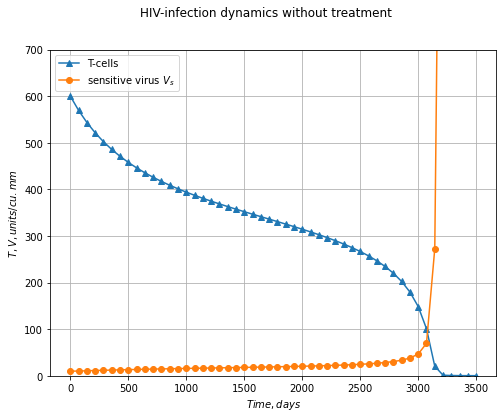

In [432]:
y0 = np.array([600, 0, 10])#начальные услловия
t0 = np.linspace(0, 3500)

solution = solve_ivp(no_treatment_HIV, (0, 3500), y0, t_eval=t0)
result = solution.y

#отрисовка графика
fig, ax = plt.subplots(figsize=(8, 6))
fig.set_facecolor('white')
        
plt.plot(solution.t, result[0], '^-', label='T-cells')
plt.plot(solution.t, result[2], 'o-', label='sensitive virus $V_s$')

plt.ylabel('$T, V, units/cu. mm$')
plt.xlabel('$Time, days$')
plt.suptitle('HIV-infection dynamics without treatment')
plt.legend()
plt.ylim(0,700)
plt.grid(True)

    
plt.show()


**Математическая модель подавления ВИЧ-инфекции**

Динамика развития заболевания описывается системой дифференциальных уравнений 7-го порядка:

\begin{equation*}
 \begin{cases}
    \frac{dT(t)}{dt} = S_1 - \frac{S_2 V(t)}{B_s + V(t)} - \mu_T T(t) + \frac{\lambda_1}{C + V(t)}T(t)V(t) - (\eta_1(t)k_S V_S(t) + k_r V_r)T(t) \\
    \frac{dT_S(t)}{dt} = \eta_1k_SV_S(t) - \mu_{T_i}T_S(t) - \frac{\lambda_2}{C_i + V}T_S(t)V(t) \\
    \frac{dT_r(t)}{dt} = k_r V_r(t) T(t) - \mu_{T_i} T_r(t) - \frac{\lambda_2}{C_i + V}T_r(t)V(t) \\
    \frac{dV_S(t)}{dt} = (1 - q) \frac{\lambda_3}{C_i + V}T_S(t)V(t) - k_V T(t)V_S(t) + \eta_2(t)  \frac{G_S V_S}{B + V} \\
    \frac{dV_r(t)}{dt} =  \frac{\lambda_3}{C_i + V}T_r(t)V(t) + q \frac{\lambda_3}{C_i + V}T_r(t)V(t) - k_V T(t)V_r(t) + G_r(V(t)) \frac{V_r}{B + V} \\
    \frac{d\eta_1(t)}{dt} = c_1(1 - \eta_1(t) - u_1) \\
    \frac{d\eta_2(t)}{dt} = \frac{c_2}{1 - c_3}(1 - \eta_2(t) + u_2(c_3 - 1)) 
 \end{cases}
\end{equation*}

С начальными условиями:
\begin{equation*}
   T(0) = 600; T_S(0) = 0; T_r(0) = 0; V_S(0) = 10; V_r(0) = 0; \eta_1(0) = 1; \eta_2(0) = 1
\end{equation*}

Запишем функцию правых частей системы:

In [433]:
def treatment_HIV(t, y, u1_a, u2_a):
    
    T, Ts, Tr, Vs, Vr, nu1, nu2 = y
    i = int(t // delta)

    V = Vs + Vr 
    u1 = u1_a[i]
    u2 = u2_a[i]
    S = S1 - S2 * V / (Bs + V)
    lam1 = lambda1 / (C + V)
    lam2 = lambda2 / (C_i + V)
    lam3 = lambda3 / (C_i + V)
    G = Gs * Vs / (B + V)
    if V < V0:
        Grv = 0
    else:
        Grv = Gs
   
    #система дифф уравнений описыващая динамику развития заболевания
    dTdt = S - muT * T + lam1 * T * V - (nu1 * kS * Vs + kr * Vr)*T
    dTsdt = nu1 * kS * Vs - muTi * Ts - lam2 * Ts * V
    dTrdt = kr * Vr * T - muTi * Tr - lam2 * Tr * V
    dVsdt = (1 - q) * lam3 * Ts * V - kV * T * Vs + nu2 * G
    dVrdt = lam3 * Tr * V + q * lam3 * Ts * V - kV * T * Vr + Grv * Vr / (B + V)
    dnu1dt = c1 * (1 -  nu1 - u1)
    dnu2dt = c2 * (1 - nu2 + u2 * (c3 - 1)) / (1 - c3)
    
    return np.array([dTdt, dTsdt, dTrdt, dVsdt, dVrdt, dnu1dt, dnu2dt])


Найдем решения и построим графики отражающие короткий и длинный периоды лечения

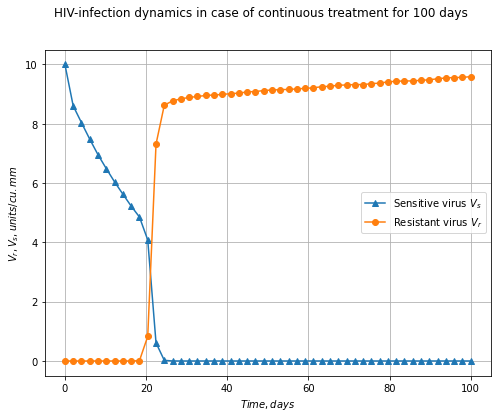

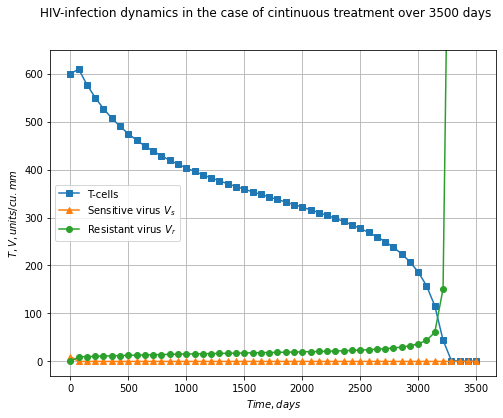

In [434]:
#короткий период лечения
y0 = np.array([600, 0, 0, 10, 0, 1, 1])#начальные условия
time_short = np.linspace(0, 100)

delta = time_short[1] - time_short[0]
u1_a = np.ones(len(t0))
u2_a = np.ones(len(t0))

solution_short = solve_ivp(lambda t, y : treatment_HIV(t, y, u1_a, u2_a), (0, 100), y0, t_eval=time_short)
result_short = solution_short.y

#отрисовка графика
fig, ax = plt.subplots(figsize=(8, 6))
fig.set_facecolor('white')
        
plt.plot(solution_short.t, result_short[3], '^-', label='Sensitive virus $V_s$')
plt.plot(solution_short.t, result_short[4], 'o-', label='Resistant virus $V_r$')

plt.ylabel('$V_r, V_s, units/cu. mm$')
plt.xlabel('$Time, days$')
plt.suptitle('HIV-infection dynamics in case of continuous treatment for 100 days')
plt.legend()
plt.grid(True)
    
plt.show()

#длительныый период лечения
time_long = np.linspace(0, 3500)

delta = time_long[1] - time_long[0]
u1_a = np.ones(len(time_long))
u2_a = np.ones(len(time_long))

solution_long = solve_ivp(lambda t, y : treatment_HIV(t, y, u1_a, u2_a), (0, 3500), y0, t_eval=time_long)
result_long = solution_long.y

#отрисовка графика
fig, ax = plt.subplots(figsize=(8, 6))
fig.set_facecolor('white')

plt.plot(solution_long.t, result_long[0], 's-', label='T-cells')       
plt.plot(solution_long.t, result_long[3], '^-', label='Sensitive virus $V_s$')
plt.plot(solution_long.t, result_long[4], 'o-', label='Resistant virus $V_r$')

plt.ylabel('$T, V, units/cu. mm$')
plt.xlabel('$Time, days$')
plt.suptitle('HIV-infection dynamics in the case of cintinuous treatment over 3500 days')
plt.legend()
plt.ylim(-30, 650)
plt.grid(True)

plt.show()

**Оптимальная программа лечения(Принцип максимума Понтрягина)**

С помощью Принципа максимума Понтрягина найдем оптимальное управление лечения. Для этого запишем гамильтониан системы и дифференциальные уравнения на сопряженные переменные
\begin{equation*}
    
 \begin{cases}
    H = p_{T}(S_1 - \frac{S_2 V(t)}{B_s + V(t)} - \mu_T T(t) + \frac{\lambda_1}{C + V(t)}T(t)V(t) - (\eta_1(t)k_S V_S(t) + k_r V_r)T(t)) + p_{T_S}(\eta_1k_SV_S(t) - \mu_{T_i}T_S(t) - \frac{\lambda_2}{C_i + V}T_S(t)V(t)) + p_{T_r}(k_r V_r(t) T(t) \\
    - \mu_{T_i} T_r(t) - \frac{\lambda_2}{C_i + V}T_r(t)V(t)) + p_{V_S}((1 - q) \frac{\lambda_3}{C_i + V}T_S(t)V(t) - k_V T(t)V_S(t) + \eta_2(t)  \frac{G_S V_S}{B + V}) + p_{V_r}(\frac{\lambda_3}{C_i + V}T_r(t)V(t) + \\
    q \frac{\lambda_3}{C_i + V}T_r(t)V(t) - k_V T(t)V_r(t) + G_r(V(t)) \frac{V_r}{B + V}) + p_{\eta_1}(c_1(1 - \eta_1(t) - u_1)) + p_{\eta_2}(\frac{c_2}{1 - c_3}(1 - \eta_2(t) + u_2(c_3 - 1)))
  \end{cases}
\end{equation*}


\begin{equation*}
 \begin{cases}
    \frac{dp_T}{dt} = -\frac{dH}{dT} \\
    \frac{dp_{T_S}}{dt} = -\frac{dH}{dT_S} \\
    \frac{dp_{T_r}}{dt} = -\frac{dH}{dT_r} \\
    \frac{dp_{V_S}}{dt} = -\frac{dH}{dV_S} \\
    \frac{dp_{V_r}}{dt} =  -\frac{dH}{dV_r} \\
    \frac{dp_{\eta_1}}{dt} = -\frac{dH}{d\eta_1} \\
    \frac{dp_{\eta_2}}{dt} = -\frac{dH}{d\eta_2}
 \end{cases}
\end{equation*}

C начальными условиями:
\begin{equation*}
   p_T(0) = 1; p_{T_S}(0) = 0; p_{T_r}(0) = 0; p_{V_S}(0) = 0; p_{V_r}(0) = 0; p_{\eta_1}(0) = 0; p_{\eta_2}(0) = 0
\end{equation*}

Запишем функции описывающие правые части системы и гамильтониан:


In [435]:
#функция описывает правые части системы ОДУ сопряженных переменных
def costate_var(t, p, param):
    
    pT, pTs, pTr, pVs, pVr, pnu1, pnu2 = p
    T_a, Ts_a, Tr_a, Vs_a, Vr_a, nu11, nu22  = param

    i = int(t//delta) 
    T, Ts, Tr, Vs, Vr, nu1, nu2 = T_a[i], Ts_a[i], Tr_a[i], Vs_a[i], Vr_a[i], nu11[i], nu22[i]
    V = Vs + Vr 
    S = S1 - S2 * V / (Bs + V)
    lam1 = lambda1 / (C + V)
    lam2 = lambda2 / (C_i + V)
    lam3 = lambda3 / (C_i + V)
    G = Gs * Vs / (B + V)
    if V < V0:
        Grv = 0
    else:
        Grv = Gs

    dpTdt = pT * (muT - lam1 * V + nu1 * kS * Vs + kr * Vr) - pTs * nu1 * kS * Vs - pTr * kr * Vr + pVs * kV * Vs + pVr * kV * Vr 
    dpTsdt = pTs * (muTi + lam2 * V) - (pVs * (1 - q) + pVr * q) * lam3 * V
    dpTrdt = pTr * (muTi + lam2 * V) - pVr * lam3 * V
    dpVsdt = pT * (S2 * Bs / (Bs + V)**2 - lam1 * T * C / (C + V) + nu1 * kS * T) - pTs * nu1 * kS * T + pVs * kV * T \
        + (pTs * lam2 * Ts  + pTr * lam2 * Tr - pVs * (1 - q) * lam3 * Ts - pVr * q * lam3 * Ts - pVr * lam3 * Tr) * C_i / (C_i + V) \
        + (pVr * Gr * Vr - pVs * nu2 * Gs * (B + Vr)) / (B + V)**2
    dpVrdt = pT * (S2 * Bs / (Bs + V)**2 - lam1 * T * C / (C + V) + kr * T) - pTr * kr * T + pVr * kV * T \
        + (pTs * lam2 * Ts  + pTr * lam2 * Tr - pVs * (1 - q) * lam3 * Ts - pVr * q * lam3 * Ts - pVr * lam3 * Tr) * C_i / (C_i + V) \
        + (pVs * nu2 * Gs * Vs - pVr * Gr * (B + Vs)) / (B + V)**2
    dpnu1dt = (pT - pTs) * kS * Vs * T + pnu1 * c1
    dpnu2dt = pnu2 * c2 / (1 - c3) - pVs * G
    
    return np.array([dpTdt, dpTsdt, dpTrdt, dpVsdt, dpVrdt, dpnu1dt, dpnu2dt])

#функция описывающая гамильтониан
def H(i, y, p, u11, u22):
    pT_a, pTs_a, pTr_a, pVs_a, pVr_a, pnu1_a, pnu2_a = p
    T_a, Ts_a, Tr_a, Vs_a, Vr_a, nu11, nu22 = y

    pT, pTs, pTr, pVs, pVr, pnu1, pnu2 = pT_a[i], pTs_a[i], pTr_a[i], pVs_a[i], pVr_a[i], pnu1_a[i], pnu2_a[i]
    T, Ts, Tr, Vs, Vr, nu1, nu2 = T_a[i], Ts_a[i], Tr_a[i], Vs_a[i], Vr_a[i], nu11[i], nu22[i]
    u1, u2 = u11[i], u22[i]

    V = Vs + Vr 
    S = S1 - S2 * V / (Bs + V)
    lam1 = lambda1 / (C + V)
    lam2 = lambda2 / (C_i + V)
    lam3 = lambda3 / (C_i + V)
    G = Gs * Vs / (B + V)
    if V < V0:
        Grv = 0
    else:
        Grv = Gs

    
    return pT * (S - muT * T + lam1 * T * V - (nu1 * kS * Vs + kr * Vr)*T) + pTs * (nu1 * kS * Vs - muTi * Ts - lam2 * Ts * V) \
        + pTr * (kr * Vr * T - muTi * Tr - lam2 * Tr * V) + pVs * ((1 - q) * lam3 * Ts * V - kV * T * Vs + nu2 * G) \
        + pVr * (lam3 * Tr * V + q * lam3 * Ts * V - kV * T * Vr + Grv * Vr / (B + V)) + pnu1 * c1 * (1 - nu1 - u1) \
        +pnu2 * (c2 * (1 - nu2 + u2 * (c3 - 1)) / (1 - c3))


Найдем решение и применим принцип максимума Понтрягина

In [436]:
time = np.linspace(0, 3500)
delta = time[1] - time[0]

u1_max = np.ones(len(t01))
u1_a = np.zeros(len(t01))
u1_min = np.zeros(len(t01))

u2_max = np.ones(len(t01))
u2_a = np.zeros(len(t01))
u2_min = np.zeros(len(t01))

#начальные условия
y0 = np.array([600, 0, 0, 10, 0, 1, 1])
p0 = np.array([1, 0, 0, 0, 0, 0, 0])

for _ in range(len(u1_a)):
    solution_y = solve_ivp(lambda t, y : treatment_HIV(t, y, u1_a, u2_min), (0, 3500), y0, t_eval=time)
    y = solution_y.y
    
    # p0 = np.array([-(S1 - S2 * (x[3,-1] + x[4,-1]) / (Bs + (x[3,-1] + x[4,-1])) - muT * x[1,-1] + lambda1 * x[1,-1] / (C + (x[3,-1] + x[4,-1])) - (x[5, -1] * kS * (x[3,-1] + x[4,-1])) * x[1,-1])**-1, 0, 0, 0, 0, 0, 0])
    solution_p = solve_ivp(lambda t, p: costate_var(t, p, y), (3500, 0), p0, t_eval=3500 - time) 
    p = solution_p.y[:,::-1] # получен в обратном порядке
    
    H0 = np.zeros(len(t01))
    H_min = np.zeros(len(t01))
    H_max = np.zeros(len(t01))

    for i in range(len(t01)):
        H_max[i] = H(i, y, p, u1_max, u2_min)
        H0[i] = H(i, y, p, u1_a, u2_min)
        H_min[i] = H(i, y, p, u1_min, u2_min)
    
    i = np.argmax(H_max - H0)
    if H_max[i] - H0[i] > 0:
        u1_a[i] = 1
    j = np.argmax(H_min - H0)
    if H_min[j] - H0[j] > 0:
        u1_a[j] = 0

for _ in range(len(u2_a)):
    solution_y2 = solve_ivp(lambda t, y : treatment_HIV(t, y, u1_min, u2_a), (0, 3500), y0, t_eval=t01)
    y2 = solution_y2.y
    
    solution_p2 = solve_ivp(lambda t, p: costate_var(t, p, y2), (3500, 0), p0, t_eval=3500 - t01) 
    p2 = solution_p2.y[:,::-1] # получен в обратном порядке
    
    H0 = np.zeros(len(t01))
    H_min = np.zeros(len(t01))
    H_max = np.zeros(len(t01))
    
    for i in range(len(t01)):
        H0[i] = H(i, y2, p2, u1_a, u2_a)
        H_max[i] = H(i, y2, p2, u1_a, u2_max)
        H_min[i] = H(i, y2, p2, u1_a, u2_min)
   
    i = np.argmax(H_max - H0)
    if H_max[i] - H0[i] > 0:
        u2_a[i] = 1
    j = np.argmax(H_min - H0)
    if H_min[j] - H0[j] > 0:
        u2_a[j] = 0

Построим графики зависимости управления от времени

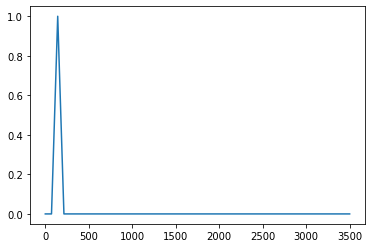

In [437]:

plt.plot(t01, u1_a)

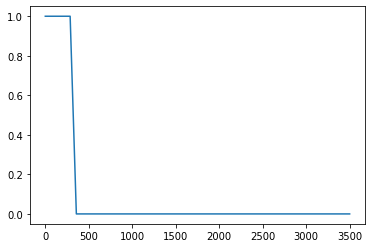

In [438]:
plt.plot(t01, u2_a)